## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Missing values

In [4]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mode()[0], inplace=True)
test['age_approx'].fillna(train['age_approx'].mode()[0], inplace=True)
# anatom_site_general_challenge (NaN)
# train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [5]:
### Label ecoding
enc = LabelEncoder()
train['sex_enc'] = enc.fit_transform(train['sex'].astype('str'))
test['sex_enc'] = enc.transform(test['sex'].astype('str'))

### One-hot ecoding
# train = pd.concat([train, pd.get_dummies(train['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# test = pd.concat([test, pd.get_dummies(test['sex'], prefix='sex_enc', drop_first=True)], axis=1)

### Mean ecoding
target_mean = train['target'].mean()
# Sex
sex_mean = train.groupby(['sex'])['target'].mean().reset_index().rename(columns={'target': 'sex_mean'})
train = train.merge(sex_mean, on=['sex'], how='left')
test = test.merge(sex_mean, on=['sex'], how='left')
train['sex_mean'].fillna(target_mean, inplace=True)
test['sex_mean'].fillna(target_mean, inplace=True)

# Age
age_mean = train.groupby(['age_approx'])['target'].mean().reset_index().rename(columns={'target': 'age_mean'})
train = train.merge(age_mean, on=['age_approx'], how='left')
test = test.merge(age_mean, on=['age_approx'], how='left')
train['age_mean'].fillna(target_mean, inplace=True)
test['age_mean'].fillna(target_mean, inplace=True)

# Sex_Age
sex_age_mean = train.groupby(['sex', 'age_approx'])['target'].mean().reset_index().rename(columns={'target': 'sex_age_mean'})
train = train.merge(sex_age_mean, on=['sex', 'age_approx'], how='left')
test = test.merge(sex_age_mean, on=['sex', 'age_approx'], how='left')
train['sex_age_mean'].fillna(target_mean, inplace=True)
test['sex_age_mean'].fillna(target_mean, inplace=True)


# External features
train_img_ft = pd.read_csv('../input/landscape/TrainSuperTab.csv')
test_img_ft = pd.read_csv('../input/landscape/TestSuperTab.csv')
ext_fts = ['V1', 'V2', 'V3', 'V4','V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 
           'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
           'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
for ft in ext_fts:
    train[ft] = train_img_ft[ft]
    test[ft] = test_img_ft[ft]

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,...,1.835102,1.428571,1.176471,0.368451,24.984602,1.309416,0.272855,0.098885,52.594848,0.428426
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,...,1.301577,1.666667,1.095238,0.391409,25.587810,1.240345,0.317342,0.125999,57.991760,0.430091
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,...,1.475337,1.531477,0.581197,0.209879,14.387222,1.272196,0.410767,0.138850,56.623874,0.423386
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,...,2.772424,1.000000,2.000000,0.643102,47.842749,1.504529,0.830075,0.271822,46.900691,0.425073
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,...,1.358362,1.479167,1.100000,0.361749,23.899347,1.310327,0.357306,0.125601,57.289260,0.428426


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,sex_mean,age_mean,sex_age_mean,V1,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,ISIC_0052060,IP_3579794,male,70.0,NaN,1,0.021231,0.029472,0.033141,0.1024,...,1.899913,1.250000,0.949153,0.326860,24.660825,1.384345,0.830075,0.231371,51.690459,0.426753
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.021231,0.006711,0.007316,0.1024,...,1.482239,1.363636,0.615385,0.184831,13.580182,1.311702,0.556334,0.186888,54.321052,0.438307
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,0.013766,0.016736,0.017094,0.1024,...,1.354060,1.666667,1.250000,0.480622,29.233718,1.236259,0.409636,0.171080,57.767034,0.425073
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,0.013766,0.012412,0.008646,0.1024,...,1.335321,1.734166,1.333333,0.626502,36.844012,1.253537,0.358360,0.153529,57.288517,0.436678
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,0.013766,0.011910,0.012232,0.1024,...,1.232224,2.222222,1.226930,0.565741,30.575912,1.260437,0.384288,0.174129,59.508983,0.425073


# Model

In [6]:
features = ['age_approx', 'sex_mean', 'age_mean', 'sex_age_mean']

ohe_features  = [col for col in train.columns if 'enc' in col]

features += ohe_features

# External features
features += ext_fts
print(features)

['age_approx', 'sex_mean', 'age_mean', 'sex_age_mean', 'sex_enc', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']


In [7]:
# Hyperparameter grid
param_grid = {
    'max_depth': list(range(2, 12, 2)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.3, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'scale_pos_weight': list(np.linspace(1, (len(train[train['target'] == 0]) / len(train[train['target'] == 1])), 10)),
}


skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)

def get_idxs():
    for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
        x_train = train[train['tfrecord'].isin(idxT)]
        x_valid = train[~train['tfrecord'].isin(idxT)]
        yield x_train.index, x_valid.index


# Model
model = XGBClassifier(n_estimators=300, random_state=SEED)

grid_search = RandomizedSearchCV(param_distributions=param_grid, estimator=model, scoring='roc_auc', 
                                 cv=iter(get_idxs()), n_jobs=-1, n_iter=100, verbose=1)
result = grid_search.fit(train[features], train['target'])

print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
params = result.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 66.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 76.5min finished


Best: 0.792410 using {'subsample': 0.6464646464646464, 'scale_pos_weight': 19.240867579908677, 'reg_lambda': 0.16326530612244897, 'reg_alpha': 0.4693877551020408, 'max_depth': 4, 'learning_rate': 0.018601183407065337, 'colsample_bytree': 0.45555555555555555}
0.783107 (0.010487) with: {'subsample': 0.7171717171717171, 'scale_pos_weight': 49.64231354642314, 'reg_lambda': 0.5918367346938775, 'reg_alpha': 0.36734693877551017, 'max_depth': 4, 'learning_rate': 0.023422900579365236, 'colsample_bytree': 0.45555555555555555}
0.735615 (0.012367) with: {'subsample': 0.51010101010101, 'scale_pos_weight': 43.56202435312025, 'reg_lambda': 0.6122448979591836, 'reg_alpha': 0.7755102040816326, 'max_depth': 8, 'learning_rate': 0.11650307053484622, 'colsample_bytree': 1.0}
0.752088 (0.024127) with: {'subsample': 0.9797979797979799, 'scale_pos_weight': 13.160578386605785, 'reg_lambda': 0.4081632653061224, 'reg_alpha': 0.36734693877551017, 'max_depth': 10, 'learning_rate': 0.12775485451762533, 'colsample_b

# Training

In [8]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0
model_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'train' if x['tfrecord'] in idxT else 'validation', axis=1)
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    model = XGBClassifier(**params, random_state=SEED)
    
    model.fit(x_train[features], y_train, eval_set=[(x_valid[features], y_valid)], eval_metric='auc', verbose=0)
    model_list.append(model)

    # Evaludation
    preds = model.predict_proba(train[features])[:, 1]
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = model.predict_proba(test[features])[:, 1]
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Model evaluation

In [9]:
def func(x):
    if x['fold_1'] == 'validation':
        return x['pred_fold_1']
    elif x['fold_2'] == 'validation':
        return x['pred_fold_2']
    elif x['fold_3'] == 'validation':
        return x['pred_fold_3']
    elif x['fold_4'] == 'validation':
        return x['pred_fold_4']
    elif x['fold_5'] == 'validation':
        return x['pred_fold_5']
    
train['pred'] = train.apply(lambda x: func(x), axis=1)

auc_oof = roc_auc_score(train['target'], train['pred'])
print(f'Overall OOF AUC = {auc_oof:.3f}')

df_oof = train[['image_name', 'target', 'pred']]
df_oof.to_csv('oof.csv', index=False)
display(df_oof.head())
display(df_oof.describe().T)

Overall OOF AUC = 0.783


,image_name,target,pred
0,ISIC_2637011,0,0.262490
1,ISIC_0015719,0,0.130832
2,ISIC_0052212,0,0.267353
3,ISIC_0068279,0,0.261717
4,ISIC_0074268,0,0.155796


,count,mean,std,min,25%,50%,75%,max
target,33126.0,0.017630,0.131603,0.000000,0.00000,0.000000,0.000000,1.000000
pred,33126.0,0.238954,0.116059,0.105437,0.14919,0.205623,0.291443,0.732893


# Feature importance

Fold: 1


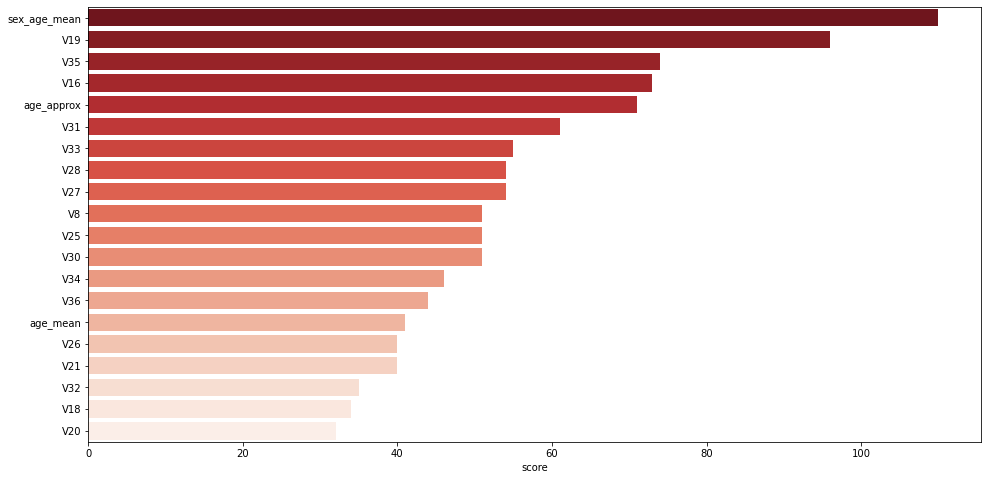

Fold: 2


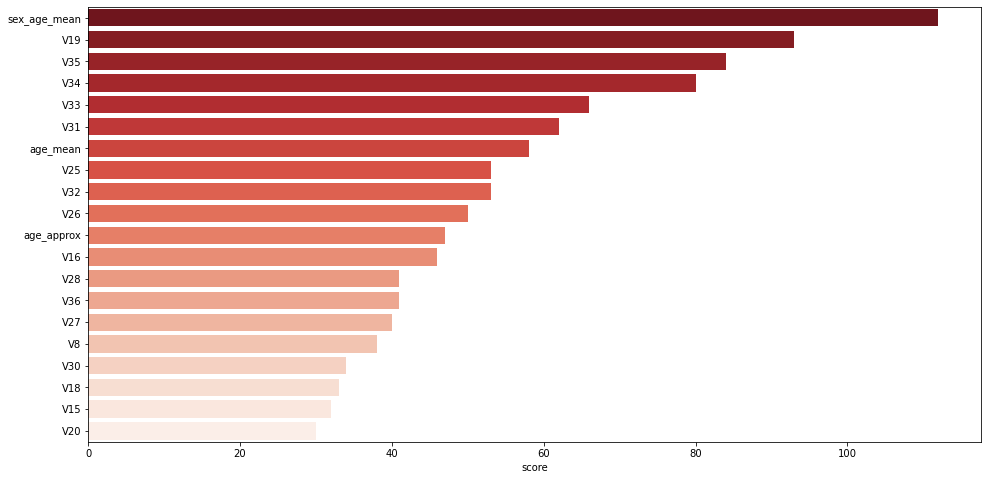

Fold: 3


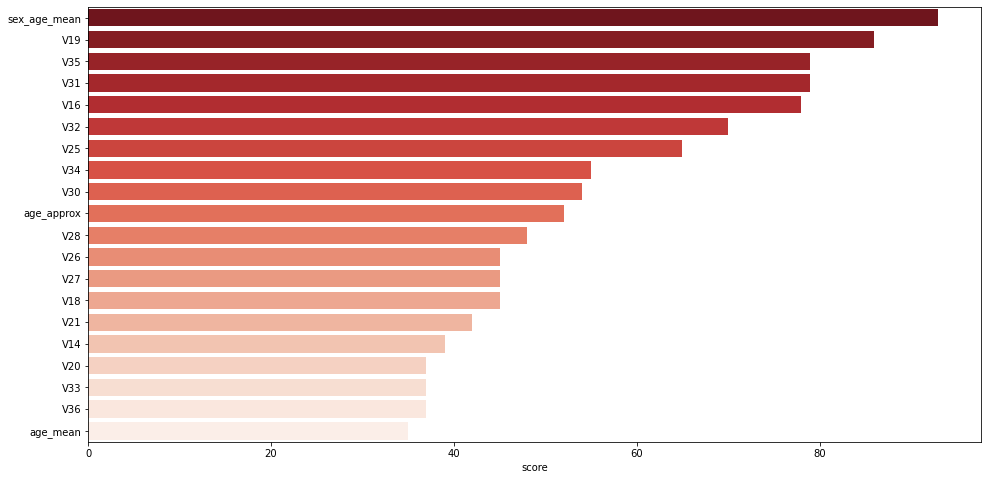

Fold: 4


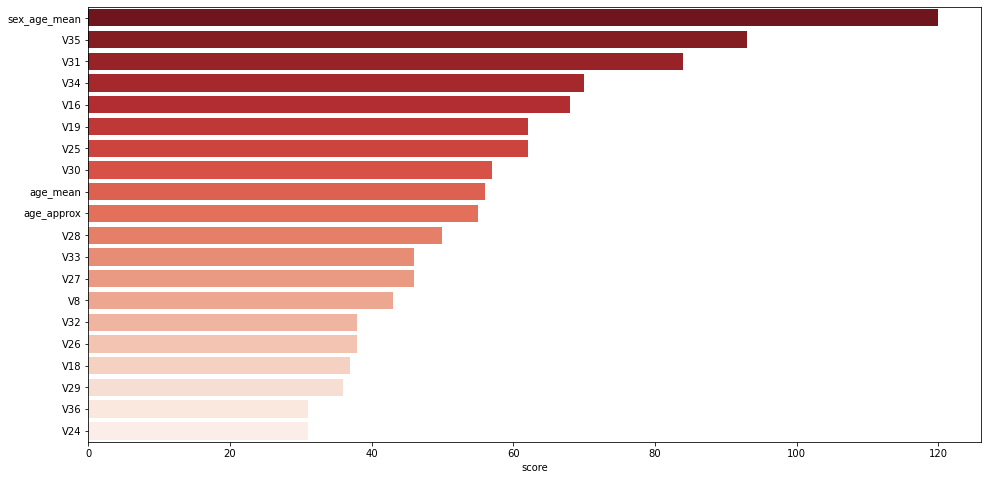

Fold: 5


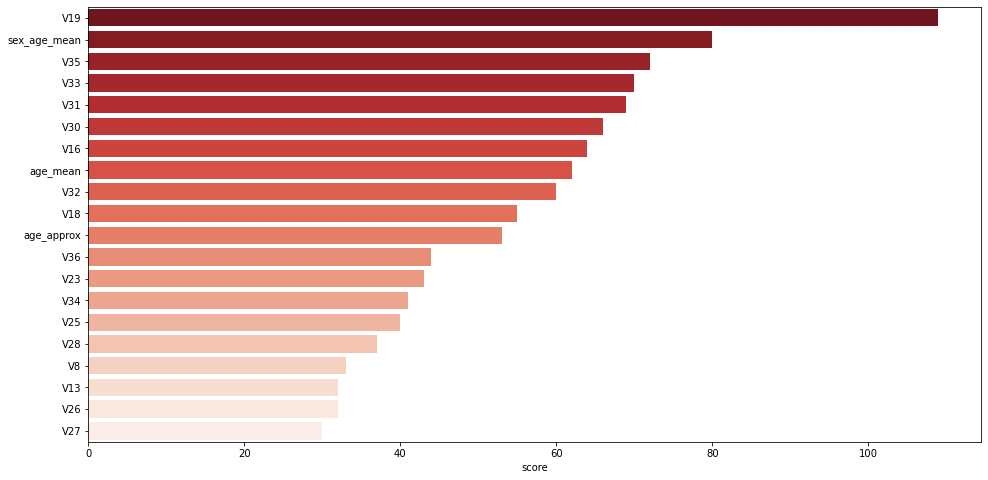

In [10]:
for n_fold, model in enumerate(model_list):
    print(f'Fold: {n_fold + 1}')
    feature_importance = model.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                              columns=['score']).sort_values(by='score',
                                                             ascending=False)
    plt.figure(figsize=(16, 8))
    sns.barplot(x=importance.score.iloc[:20],
                y=importance.index[:20],
                orient='h',
                palette='Reds_r')

    plt.show()

# Model evaluation

In [11]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.862691,0.785563,0.077128,0.862126,0.800699,0.862946,0.771151,0.865326,0.776471,0.865387,0.784323,0.857670,0.795172
Accuracy,0.952283,0.948393,0.003890,0.954695,0.943185,0.950914,0.945465,0.950000,0.948325,0.949001,0.949345,0.956805,0.955645
Precision,0.165872,0.096606,0.069266,0.170932,0.103152,0.158465,0.088328,0.162660,0.101974,0.158556,0.085409,0.178744,0.104167
Recall,0.416085,0.241667,0.174419,0.402151,0.302521,0.408602,0.235294,0.436559,0.260504,0.434409,0.201681,0.398707,0.208333
F1-score,0.236884,0.137550,0.099335,0.239897,0.153846,0.228365,0.128440,0.237011,0.146572,0.232317,0.120000,0.246831,0.138889
Support,464.800000,119.200000,345.600000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,464.000000,120.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.862691,0.785563,0.077128,0.862126,0.800699,0.862946,0.771151,0.865326,0.776471,0.865387,0.784323,0.857670,0.795172
male,0.851876,0.772741,0.079135,0.853773,0.776674,0.844469,0.793091,0.862130,0.726929,0.857750,0.766514,0.841261,0.800497
female,0.872056,0.790252,0.081804,0.868256,0.827626,0.881221,0.726641,0.865487,0.818985,0.870507,0.805466,0.874809,0.772543
head/neck,0.847653,0.789622,0.058031,0.843350,0.814390,0.827630,0.899651,0.883247,0.651408,0.845079,0.801500,0.838961,0.781161
upper extremity,0.870308,0.791055,0.079253,0.877040,0.784623,0.864878,0.796565,0.876696,0.782447,0.872600,0.784645,0.860328,0.806996
lower extremity,0.800456,0.716882,0.083574,0.795954,0.737249,0.810453,0.601554,0.795782,0.767949,0.800670,0.733306,0.799420,0.744350
torso,0.892681,0.823705,0.068976,0.888397,0.852964,0.898812,0.804913,0.889671,0.830343,0.897308,0.805258,0.889219,0.825047
0 <= age < 26,0.862503,0.757730,0.104773,0.841768,0.791186,0.877567,0.516979,0.863711,0.938492,0.852264,0.831948,0.877204,0.710044
26 <= age < 40,0.860431,0.775967,0.084464,0.859132,0.768459,0.849259,0.856286,0.866209,0.752960,0.883086,0.686167,0.844467,0.815960


# Adversarial Validation

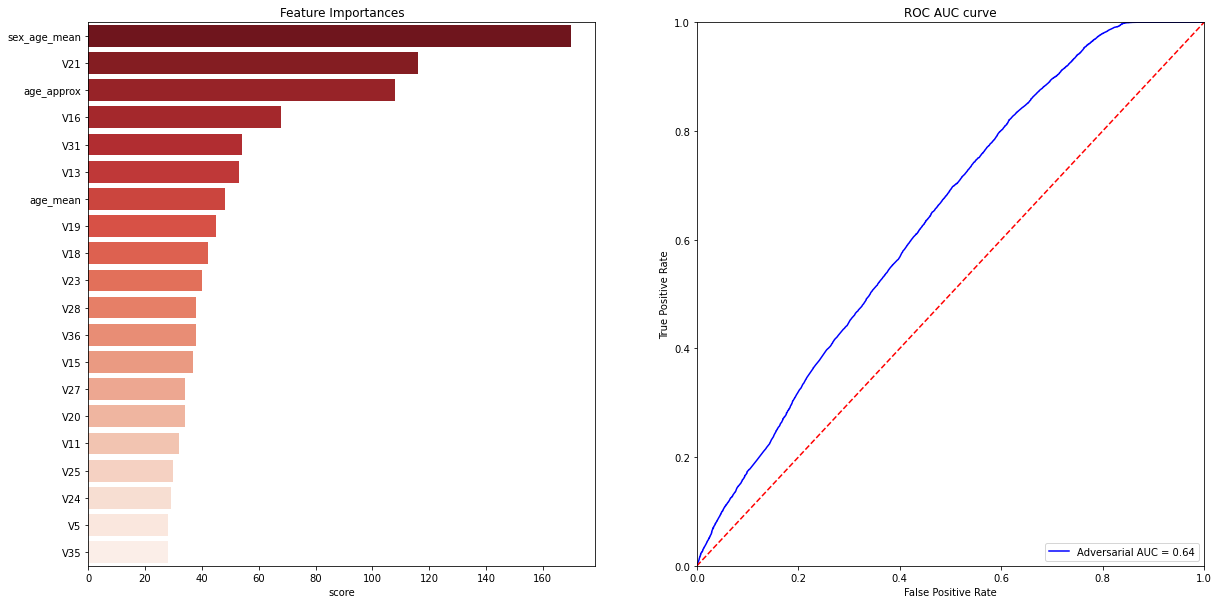

In [12]:
### Adversarial set
adv_train = train.copy()
adv_test = test.copy()
adv_train['dataset'] = 1
adv_test['dataset'] = 0

x_adv = pd.concat([adv_train, adv_test], axis=0)
y_adv = x_adv['dataset']

### Adversarial model
model_adv = XGBClassifier(**params, random_state=SEED)

model_adv.fit(x_adv[features], y_adv, eval_metric='auc', verbose=0)


### Preds
preds = model_adv.predict_proba(x_adv[features])[:, 1]


### Plot feature importance and ROC AUC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Feature importance
feature_importance = model_adv.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)

ax1.set_title('Feature Importances')
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r',
            ax=ax1)

# Plot ROC AUC curve
fpr_train, tpr_train, _ = roc_curve(y_adv, preds)
roc_auc_train = auc(fpr_train, tpr_train)

ax2.set_title('ROC AUC curve')
ax2.plot(fpr_train, tpr_train, color='blue', label='Adversarial AUC = %0.2f' % roc_auc_train)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

# Visualize predictions

In [13]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 1391
Train positive correct predictions: 215
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.233949,0.262490,0.222383,0.238135,0.210045,0.236692
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.131396,0.130832,0.133908,0.134287,0.126711,0.131240
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.246209,0.239139,0.238885,0.259585,0.226081,0.267353
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.236562,0.261717,0.201715,0.238846,0.223312,0.257218
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.159939,0.155796,0.169263,0.154198,0.163013,0.157426
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.148998,0.152811,0.146160,0.158929,0.139820,0.147271
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.154810,0.154688,0.160181,0.155181,0.155620,0.148378
7,ISIC_0075663,female,35.0,torso,unknown,0,0.261604,0.253359,0.266606,0.252227,0.265008,0.270820
8,ISIC_0075914,male,30.0,torso,unknown,0,0.157537,0.163764,0.163546,0.155157,0.153695,0.151522
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.152103,0.144258,0.161211,0.167988,0.144156,0.142903


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.178804,0.172248,0.189902,0.181775,0.190438,0.159657
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.357949,0.333065,0.289194,0.395585,0.353850,0.418050
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.393656,0.407966,0.387353,0.348030,0.448044,0.376885
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.388402,0.392659,0.384529,0.393627,0.429555,0.341642
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.350051,0.375399,0.318059,0.363747,0.327730,0.365321
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.490598,0.538536,0.451598,0.506157,0.504764,0.451934
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.272754,0.283236,0.282458,0.297426,0.208743,0.291906
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.545334,0.585198,0.472007,0.581640,0.525834,0.561991
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.637760,0.690764,0.642391,0.709035,0.528985,0.617628
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.184529,0.237817,0.189902,0.181678,0.151437,0.161809


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
68,ISIC_0109568,male,80.0,lower extremity,unknown,0,0.521583,0.541249,0.509841,0.588297,0.453326,0.515201
120,ISIC_0157923,female,65.0,torso,nevus,0,0.565743,0.580861,0.560600,0.626525,0.535377,0.525354
136,ISIC_0162967,male,65.0,head/neck,unknown,0,0.539506,0.534116,0.564433,0.509157,0.545386,0.544436
148,ISIC_0164603,female,75.0,upper extremity,unknown,0,0.520240,0.553745,0.491008,0.480863,0.583912,0.491670
165,ISIC_0170008,female,65.0,lower extremity,unknown,0,0.573315,0.529849,0.606908,0.657784,0.487290,0.584743
172,ISIC_0170676,male,75.0,upper extremity,unknown,0,0.607758,0.629956,0.595923,0.583504,0.624421,0.604986
231,ISIC_0187428,female,65.0,lower extremity,unknown,0,0.502056,0.510791,0.505285,0.525804,0.496378,0.472023
237,ISIC_0188955,male,75.0,lower extremity,nevus,0,0.627927,0.613862,0.583225,0.682643,0.646840,0.613067
238,ISIC_0189059,male,75.0,torso,nevus,0,0.698805,0.700733,0.681013,0.706250,0.692343,0.713684
239,ISIC_0189333,female,85.0,head/neck,unknown,0,0.509267,0.519944,0.476721,0.488227,0.565528,0.495914


# Visualize test predictions

In [14]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 455|10527
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.449963,0.434518,0.478169,0.438965,0.486773,0.411391
1,ISIC_0052349,male,40.0,lower extremity,0.258954,0.225318,0.274810,0.276955,0.225514,0.292175
2,ISIC_0058510,female,55.0,torso,0.140377,0.142290,0.154195,0.132262,0.133929,0.139208
3,ISIC_0073313,female,50.0,torso,0.113935,0.115014,0.115634,0.109859,0.115137,0.114029
4,ISIC_0073502,female,45.0,lower extremity,0.120761,0.129213,0.114335,0.115464,0.121710,0.123082
5,ISIC_0074618,male,50.0,lower extremity,0.295970,0.285857,0.322676,0.274611,0.319657,0.277047
6,ISIC_0076801,male,45.0,upper extremity,0.369126,0.391517,0.360490,0.389539,0.345064,0.359017
7,ISIC_0077586,male,50.0,lower extremity,0.130105,0.143051,0.128216,0.121571,0.128611,0.129075
8,ISIC_0082004,female,45.0,torso,0.122366,0.132592,0.113259,0.118843,0.121710,0.125424
9,ISIC_0082785,male,65.0,lower extremity,0.399740,0.406882,0.421842,0.383505,0.421227,0.365245


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
24,ISIC_0112420,female,65.0,torso,0.641924,0.652571,0.663297,0.687717,0.600568,0.605470
56,ISIC_0169906,male,85.0,torso,0.622428,0.664958,0.633588,0.671935,0.571653,0.570003
67,ISIC_0178741,female,70.0,upper extremity,0.528445,0.526393,0.525056,0.493297,0.605602,0.491878
69,ISIC_0182213,female,80.0,head/neck,0.503320,0.479858,0.581803,0.498062,0.522943,0.433935
71,ISIC_0183449,female,60.0,lower extremity,0.517381,0.464898,0.533717,0.491744,0.566844,0.529702
109,ISIC_0216447,male,80.0,head/neck,0.519303,0.586718,0.449080,0.532945,0.482206,0.545568
175,ISIC_0274789,male,80.0,torso,0.669061,0.691695,0.638120,0.654464,0.629979,0.731049
196,ISIC_0292996,female,70.0,lower extremity,0.500139,0.506662,0.555266,0.541932,0.438942,0.457892
215,ISIC_0311235,male,75.0,NaN,0.622561,0.645324,0.609713,0.570487,0.676083,0.611199
228,ISIC_0327756,male,65.0,NaN,0.555353,0.555426,0.539030,0.561270,0.567685,0.553354


# Test set predictions

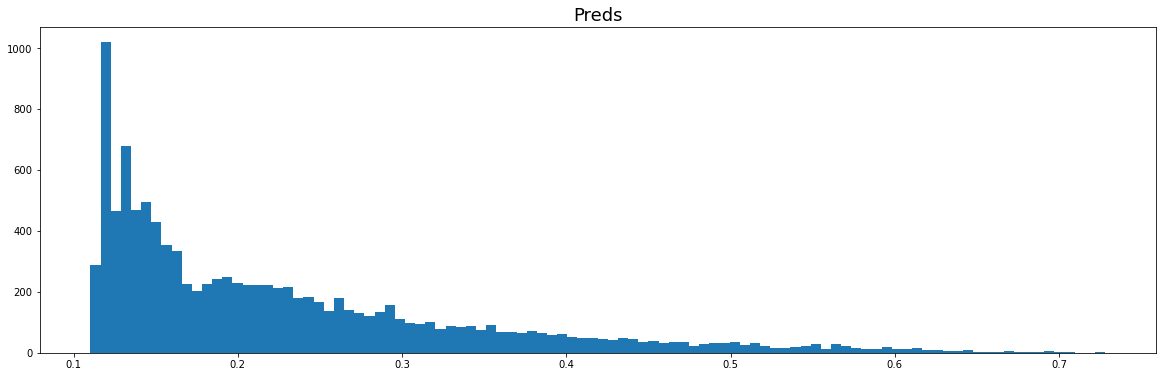

,image_name,target
0,ISIC_0052060,0.449963
1,ISIC_0052349,0.258954
2,ISIC_0058510,0.140377
3,ISIC_0073313,0.113935
4,ISIC_0073502,0.120761
5,ISIC_0074618,0.295970
6,ISIC_0076801,0.369126
7,ISIC_0077586,0.130105
8,ISIC_0082004,0.122366
9,ISIC_0082785,0.399740


,target
count,10982.000000
mean,0.229015
std,0.116170
min,0.110269
25%,0.138964
50%,0.192419
75%,0.282995
max,0.727923


In [15]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']

fig = plt.subplots(figsize=(20, 6))
plt.hist(submission['target'], bins=100)
plt.title('Preds', size=18)
plt.show()

display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)